# Workflow for a ReAct Agent

This notebook walks through setting up a `Workflow` to construct a ReAct agent from (mostly) scratch.

React calling agents work by prompting an LLM to either invoke tools/functions, or return a final response.

Our workflow will be stateful with memory, and will be able to call the LLM to select tools and process incoming user messages.

# 防断开

In [ ]:
#@markdown <h3>← 输入了代码后运行以防止断开</h>
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }

   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }

setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [ ]:
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);

In [ ]:
!pip install -U llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.5/361.5 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfull

In [ ]:
import os

os.environ["DEEPSEEK_API_KEY"] = "sk-"

# Set up LLM

In [ ]:
!pip install llama_index-llms-openai_like
!pip install llama_index-embeddings-huggingface

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import os
import logging
import sys
from llama_index.llms.openai_like import OpenAILike
from llama_index.core import Settings, ServiceContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# 配置日志
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# 定义DeepSpeed model
llm = OpenAILike(model="deepseek-chat",
                 api_base="https://api.deepseek.com/v1",
                 api_key=os.environ["DEEPSEEK_API_KEY"],
                 temperature=0.6,
                 is_chat_model=True)

# 配置环境
Settings.llm = llm

# 设置嵌入模型
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-zh-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 256
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/95.8M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/439k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-8-f86546c39a13>:25: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


Since workflows are async first, this all runs fine in a notebook. If you were running in your own code, you would want to use `asyncio.run()` to start an async event loop if one isn't already running.

```python
async def main():
    <async code>

if __name__ == "__main__":
    import asyncio
    asyncio.run(main())
```

## Designing the Workflow

An agent consists of several steps
1. Handling the latest incoming user message, including adding to memory and preparing the chat history
2. Using the chat history and tools to construct a ReAct prompt
3. Calling the llm with the react prompt, and parsing out function/tool calls
4. If no tool calls, we can return
5. If there are tool calls, we need to execute them, and then loop back for a fresh ReAct prompt using the latest tool calls

### The Workflow Events

To handle these steps, we need to define a few events:
1. An event to handle new messages and prepare the chat history
2. An event to prompt the LLM with the react prompt
3. An event to trigger tool calls, if any
4. An event to handle the results of tool calls, if any

The other steps will use the built-in `StartEvent` and `StopEvent` events.

In addition to events, we will also use the global context to store the current react reasoning!

In [ ]:
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import ToolSelection, ToolOutput
from llama_index.core.workflow import Event


class PrepEvent(Event):
    pass


class InputEvent(Event):
    input: list[ChatMessage]


class ToolCallEvent(Event):
    tool_calls: list[ToolSelection]


class FunctionOutputEvent(Event):
    output: ToolOutput

### The Workflow Itself

With our events defined, we can construct our workflow and steps.

Note that the workflow automatically validates itself using type annotations, so the type annotations on our steps are very helpful!

In [20]:
from typing import Any, List
from llama_index.core.agent.react import ReActChatFormatter, ReActOutputParser
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.tools.types import BaseTool
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)


class ReActAgent(Workflow):
    def __init__(
        self,
        *args: Any,
        llm: LLM | None = None,
        tools: list[BaseTool] | None = None,
        extra_context: str | None = None,
        **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.tools = tools or []

        self.llm = Settings.llm

        self.memory = ChatMemoryBuffer.from_defaults(llm=llm)
        self.formatter = ReActChatFormatter(context=extra_context or "")
        self.output_parser = ReActOutputParser()
        self.sources = []

    @step(pass_context=True)
    async def new_user_msg(self, ctx: Context, ev: StartEvent) -> PrepEvent:
        # clear sources
        self.sources = []

        # get user input
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        self.memory.put(user_msg)

        # clear current reasoning
        ctx.data["current_reasoning"] = []

        return PrepEvent()

    @step(pass_context=True)
    async def prepare_chat_history(
        self, ctx: Context, ev: PrepEvent
    ) -> InputEvent:
        # get chat history
        chat_history = self.memory.get()
        current_reasoning = ctx.data.get("current_reasoning", [])
        llm_input = self.formatter.format(
            self.tools, chat_history, current_reasoning=current_reasoning
        )
        return InputEvent(input=llm_input)

    @step(pass_context=True)
    async def handle_llm_input(
        self, ctx: Context, ev: InputEvent
    ) -> ToolCallEvent | StopEvent:
        chat_history = ev.input

        response = await self.llm.achat(chat_history)

        try:
            reasoning_step = self.output_parser.parse(response.message.content)
            ctx.data.get("current_reasoning", []).append(reasoning_step)
            if reasoning_step.is_done:
                self.memory.put(
                    ChatMessage(
                        role="assistant", content=reasoning_step.response
                    )
                )
                return StopEvent(
                    result={
                        "response": reasoning_step.response,
                        "sources": [*self.sources],
                        "reasoning": ctx.data.get("current_reasoning", []),
                    }
                )
            elif isinstance(reasoning_step, ActionReasoningStep):
                tool_name = reasoning_step.action
                tool_args = reasoning_step.action_input
                return ToolCallEvent(
                    tool_calls=[
                        ToolSelection(
                            tool_id="fake",
                            tool_name=tool_name,
                            tool_kwargs=tool_args,
                        )
                    ]
                )
        except Exception as e:
            ctx.data.get("current_reasoning", []).append(
                ObservationReasoningStep(
                    observation=f"There was an error in parsing my reasoning: {e}"
                )
            )

        # if no tool calls or final response, iterate again
        return PrepEvent()

    @step(pass_context=True)
    async def handle_tool_calls(
        self, ctx: Context, ev: ToolCallEvent
    ) -> PrepEvent:
        tool_calls = ev.tool_calls
        tools_by_name = {tool.metadata.get_name(): tool for tool in self.tools}

        # call tools -- safely!
        for tool_call in tool_calls:
            tool = tools_by_name.get(tool_call.tool_name)
            if not tool:
                ctx.data.get("current_reasoning", []).append(
                    ObservationReasoningStep(
                        observation=f"Tool {tool_call.tool_name} does not exist"
                    )
                )
                continue

            try:
                tool_output = tool(**tool_call.tool_kwargs)
                self.sources.append(tool_output)
                ctx.data.get("current_reasoning", []).append(
                    ObservationReasoningStep(observation=tool_output.content)
                )
            except Exception as e:
                ctx.data.get("current_reasoning", []).append(
                    ObservationReasoningStep(
                        observation=f"Error calling tool {tool.metadata.get_name()}: {e}"
                    )
                )

        # prep the next iteraiton
        return PrepEvent()

And thats it! Let's explore the workflow we wrote a bit.

`new_user_msg()`:
Adds the user message to memory, and clears the global context to keep track of a fresh string of reasoning.

`prepare_chat_history()`:
Prepares the react prompt, using the chat history, tools, and current reasoning (if any)

`handle_llm_input()`:
Prompts the LLM with our react prompt, and uses some utility functions to parse the output. If there are no tool calls, we can stop and emit a `StopEvent`. Otherwise, we emit a `ToolCallEvent` to handle tool calls. Lastly, if there are no tool calls, and no final response, we simply loop again.

`handle_tool_calls()`:
Safely calls tools with error handling, adding the tool outputs to the current reasoning. Then, by emitting a `PrepEvent`, we loop around for another round of ReAct prompting and parsing.

## Run the Workflow!

**NOTE:** With loops, we need to be mindful of runtime. Here, we set a timeout of 120s.

In [ ]:
from llama_index.core.tools import FunctionTool


def add(x: int, y: int) -> int:
    """Useful function to add two numbers."""
    return x + y


def multiply(x: int, y: int) -> int:
    """Useful function to multiply two numbers."""
    return x * y


tools = [
    FunctionTool.from_defaults(add),
    FunctionTool.from_defaults(multiply),
]

agent = ReActAgent(
    llm=Settings.llm, tools=tools, timeout=120, verbose=True
)

ret = await agent.run(input="Hello!")

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent


In [ ]:
print(ret["response"])

Hello! How can I assist you today?


In [ ]:
ret = await agent.run(input="What is (2123 + 2321) * 312?")

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent


In [ ]:
print(ret["response"])

The result of (2123 + 2321) * 312 is 1386528.


# Show workflow

In [26]:
!pip install pyvis

In [27]:
from llama_index.core.workflow import draw_all_possible_flows

draw_all_possible_flows(ReActAgent, filename="react_agent_workflow.html")

react_agent_workflow.html


<ipython-input-27-221a480a60d0>:3: DeprecationWarning: Call to deprecated function (or staticmethod) draw_all_possible_flows. (Install `llama-index-utils-workflow` and use the import `from llama_index.utils.workflow` instead.)
  draw_all_possible_flows(ReActAgent, filename="react_agent_workflow.html")


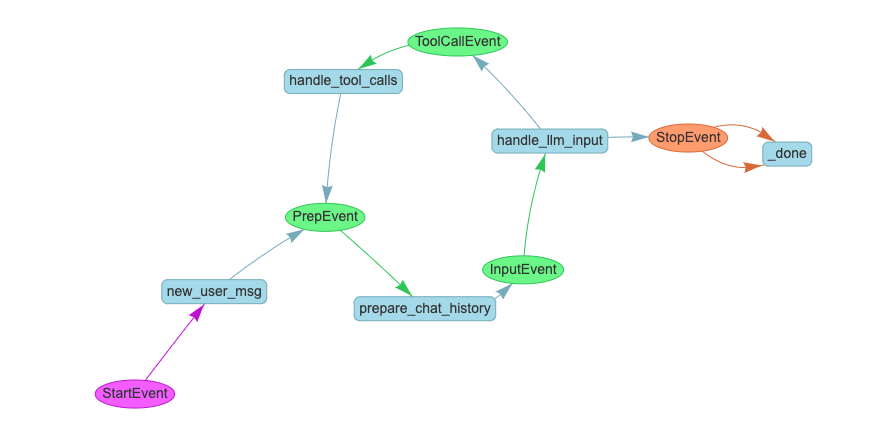